## Goal of this notebook
Explore NetworkX and DAGs. Here you'll find the following functions:

- `build_DAG` transforms the depedencies in a structure form to fill `NetworkX` DiGraph

- `is_valid_DAG` checks if the DAG is valid

- `next_tasks` gets the next tasks to be run based in some change which might be in a script or in a data file.

- `build_argo_yaml` build the yaml file to send to kubernetes (I need to test it yet)

#### TODO's and Improvements
- Add more features in the function `is_valid_DAG`

- `next_tasks` just outputs ONE list in a sorted order to fill argo's template so it won't be able to deal with parallel tasks for now, it will run one task after another. It should return a dicionary with tasks and dependencies but for now I'll consider that they just dependes on the previous step.

- Test current the generate dag in minikube

- Nicer visualization

- Tensorflow Dashboard has a lot of nice visualizations, check which library they use to do it.


I've heard a lot of concerns about NetworkX and [scalability](https://stackoverflow.com/questions/7978840/what-scalability-issues-are-associated-with-networkx) but I think it might be a problem for this project since the projects don't have crazy volumes of dependencies.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [1]:
tasks = {
    'preprocessing': {
        'inputs': ['train.csv', 'test.csv'],
        'outputs': ['clean_train.csv', 'clean_test.csv'],
        'image': 'docker/{job-id}',
        'command': 'python preprocessing.py'
    }, 
    'split': {
        'inputs': ['clean_train.csv', 'clean_test.csv'],
        'outputs': ['X_train.csv', 'y_train.csv', 'X_val.csv', 'y_val.csv'] ,
        'image': 'docker/{job-id}',
        'command': 'python split.py'
    }, 
    'train': {
        'inputs': ['X_train.csv', 'y_train.csv', 'X_val.csv', 'y_val.csv'],
        'outputs': ['trained_model.pkl'],
        'image': 'docker/{job-id}',
        'command': 'python train.py'
    }, 
    'score_test': {
        'inputs': ['trained_model.pkl', 'clean_test.csv'],
        'outputs': ['scored_test.csv'],
        'image': 'docker/{job-id}',
        'command': 'python score_test.py'
        }
}

In [3]:
def build_DAG(tasks):
    edges = []
    attrs = {}
    
    for t in tasks:
        task = tasks[t]
        edges += [(input_, t) for input_ in task['inputs']]
        edges += [(t, output_) for output_ in task['outputs']]
        
        attrs[t] = {'type': 'operator'}
        attrs.update(dict([[x, {'type': 'data'}] 
                           for x in task['inputs'] + task['outputs']]))
        
    return edges, attrs

In [4]:
edges, nodes_attr = build_DAG(tasks)

dag = nx.DiGraph(edges)
nx.set_node_attributes(dag, nodes_attr)
colors = ['blue' if dag.node[n]['type'] == 'data' else 'red' for n in dag.nodes()]

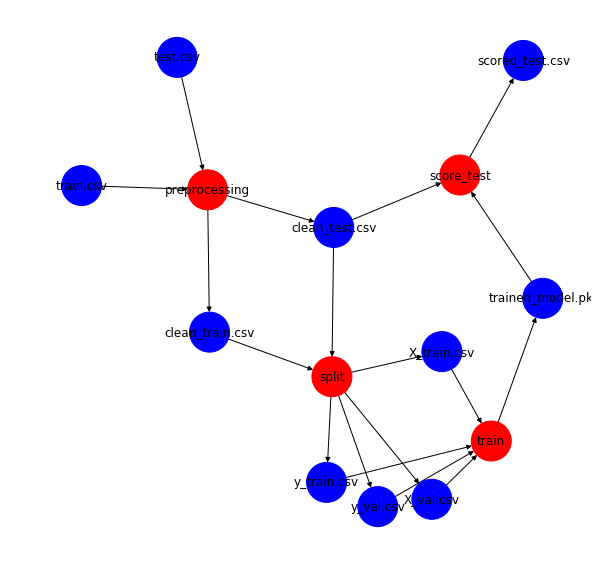

In [5]:
plt.figure(figsize=(10, 10)) 
limits = plt.axis('off')

nx.draw_networkx(dag, 
                 pos=graphviz_layout(dag), 
                 node_size=1600, 
                 node_color=colors, 
                 prog='dot')

In [6]:
def is_DAG_valid(dag):
    # TODO: add more test such as no missing nodes and no nodes alone
    return nx.is_directed_acyclic_graph(dag)

is_DAG_valid(dag)

True

In [7]:
def create_subgraph(G, node):
    edges = nx.dfs_successors(G, node)
    nodes = []
    
    for k,v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
        
    return G.subgraph(nodes)


def next_tasks(dag, changed_step):
    sub_dag = create_subgraph(dag, changed_step)
    
    sorted_sub_dag = nx.lexicographical_topological_sort(sub_dag)
    data_sub_dag = sub_dag.nodes(data=True) 
    
    pendent_tasks = [node for node in sorted_sub_dag
                     if data_sub_dag[node]['type'] == 'operator']

    return pendent_tasks

In [8]:
next_tasks(dag, 'split') == ['split', 'train', 'score_test']

True

In [9]:
next_tasks(dag, 'X_val.csv') == ['train', 'score_test']

True

In [10]:
tasks_to_run = next_tasks(dag, 'clean_train.csv') 
data_to_run = {}

for t in tasks_to_run:
    data_to_run[t] = {'image': tasks[t]['image'], 
                      'command': tasks[t]['command']}

In [11]:
data_to_run

{'split': {'image': 'docker/{job-id}', 'command': 'python split.py'},
 'train': {'image': 'docker/{job-id}', 'command': 'python train.py'},
 'score_test': {'image': 'docker/{job-id}', 'command': 'python score_test.py'}}

In [12]:
argo_header = """
apiVersion: argoproj.io/v1alpha1
kind: Workflow
metadata:
  generateName: {job_name}
spec:
  entrypoint: {first_task}
  templates:
"""

argo_template = """
- name: {task}
    container:
      image: {task_image}
      command: [{task_command}]
"""

argo_dag_header = """
- name: {job_name}
    dag:
      tasks:
      - name: {first_task}
        template: {first_task}
"""


argo_dag = """
- name: {task_name}
        dependencies: [{previous_task}]
        template: {task_name}
"""

In [13]:
def build_argo_yaml(tasks_to_run, data_to_run):
    header = argo_header.format(job_name='my-job', 
                            first_task=tasks_to_run[0])

    templates = [argo_template.format(task=t, 
                                      task_image=data_to_run[t]['image'], 
                                      task_command=data_to_run[t]['command']) 
                 for t in data_to_run]

    dag_header = argo_dag_header.format(job_name='my-job',
                                        first_task=tasks_to_run[0])

    dag = [argo_dag.format(task_name=tasks_to_run[i],
                           previous_task=tasks_to_run[i-1]) 
           for i in range(1, len(tasks_to_run))]

    return ''.join([header] + templates + [dag_header] + dag)

In [14]:
build_argo_yaml(tasks_to_run, data_to_run)

'\napiVersion: argoproj.io/v1alpha1\nkind: Workflow\nmetadata:\n  generateName: my-job\nspec:\n  entrypoint: split\n  templates:\n\n- name: split\n    container:\n      image: docker/{job-id}\n      command: [python split.py]\n\n- name: train\n    container:\n      image: docker/{job-id}\n      command: [python train.py]\n\n- name: score_test\n    container:\n      image: docker/{job-id}\n      command: [python score_test.py]\n\n- name: my-job\n    dag:\n      tasks:\n      - name: split\n        template: split\n\n- name: train\n        dependencies: [split]\n        template: train\n\n- name: score_test\n        dependencies: [train]\n        template: score_test\n'